# Initialization

In [99]:
import numpy as np
from matplotlib import pyplot as plt

# for p-value out of significance test
from scipy.stats import ttest_ind

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# for svm
from libsvm.svmutil import *

# Data Handling

### Uncompress compressed files

In [128]:
%%capture
!unzip -n ../data/images.zip -d ../data

### Custom functions

In [177]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(
            Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8'
        ) for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = len(data)
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, Y.flatten(), X_test, Y_test.flatten(), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

### Data extraction

In [130]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")

p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("--------------------------- Data Shapes ------------------------------")
print("    (Regression) p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
print("    (Regression) p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("(Classification) p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("(Classification)  p4[data]:", p4["data"].shape)
print("(Classification)  p5[data]:     ", p5["data"].shape)

--------------------------- Data Shapes ------------------------------
    (Regression) p1[train]:       (10000, 3) , p1[test]:  (5000, 3)
    (Regression) p2[train]:       (10000, 4) , p2[test]:  (5000, 4)
(Classification) p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
(Classification)  p4[data]: (10, 6000, 8, 8)
(Classification)  p5[data]:      (60000, 11)


In [131]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }
    
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

p3["classStats"] = classStats
p3["X"], p3["Y"] = splitData(p3["train"])
p3["X_test"], p3["Y_test"] = splitData(p3["test"])

p3["X"].shape, p3["Y"].shape, p3["X_test"].shape, p3["Y_test"].shape

((60000, 10), (60000,), (15000, 10), (15000,))

In [132]:
p4["X"], p4["Y"], p4["X_test"], p4["Y_test"], p4["classStats"] = trainTestSplit(p4["data"], 0.7, imgToFeatures)

p4["X"].shape, p4["Y"].shape, p4["X_test"].shape, p4["Y_test"].shape

((42000, 64), (42000,), (18000, 64), (18000,))

In [178]:
classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["X"], p5["Y"], p5["X_test"], p5["Y_test"], p5["classStats"] = trainTestSplit(np.array(classWiseData), 0.5, stats)
p5["X"].shape, p5["Y"].shape, p5["X_test"].shape, p5["Y_test"].shape

((30000, 10), (30000,), (30000, 10), (30000,))

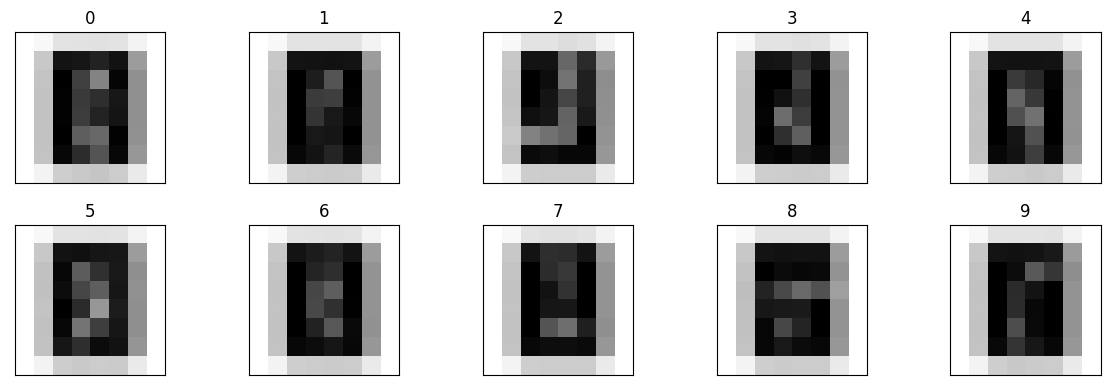

In [134]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(p4["data"].shape[0]):
    ax[i // 5][i % 5].imshow(p4["data"][i][0].astype(np.uint8), cmap='gray')
    ax[i // 5][i % 5].set_title(str(i))
    ax[i // 5][i % 5].get_xaxis().set_visible(False)
    ax[i // 5][i % 5].get_yaxis().set_visible(False)

fig.tight_layout()

# Custom common functions

In [197]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p, r = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p * r / (p + r + 1e-8)
        return f1      
    
    def print(pred, Y, pred_test, Y_test, result=False):
        n_labels = len(np.unique(Y))
                
        cnf_train = metrics.confusionMatrix(pred, Y, n_labels)
        cnf_test = metrics.confusionMatrix(pred_test, Y_test, n_labels)
        acc_train = metrics.accuracy(pred, Y)
        acc_test = metrics.accuracy(pred_test, Y_test)
        f1_train = metrics.f1Score(cnf_train)
        f1_test = metrics.f1Score(cnf_test)
        
        print("------------------ Train ---------------------")
        print("Classification Accuracy : ", acc_train * 100, "%")
        print("F1 Score                : ", f1_train)
        print("------------------ Test ----------------------")
        print("Classification Accuracy : ", acc_test * 100, "%")
        print("F1 Score                : ", f1_test)
        print("Confusion Matrix        : ")
        print(cnf_test)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].matshow(cnf_train.T, cmap='GnBu')
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")
        ax[0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        ax[1].matshow(cnf_test.T, cmap='GnBu')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")
        ax[1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[1].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        if result:
            return [acc_train, f1_train], [acc_test, f1_test]

# P1 (SVM)

- For the classification problems given in A1, implement SVMs both with and without slack formulations. 
- Experiment with at least 3 Kernels and grid search on hyper-parameters on different kernels.
- Report your observations (you can use standard python library, LibSVM and need not implement SMO). 
- For multi-class classification, implement a one-vs-rest approach.

**DATA:** `p3train/test.csv`, `images.zip (p4[data])`

In [28]:
np.unique(Y)

array([1., 2., 3., 4., 5.])

In [10]:
# https://www.csie.ntu.edu.tw/~cjlin/libsvm/
# https://github.com/prathmachowksey/Fisher-Linear-Discriminant-Analysis/blob/master/fisher_lda.ipynb
# https://python-course.eu/machine-learning/linear-discriminant-analysis-in-python.php

X, Y = parseData(p3["train"])
X_test, Y_test = parseData(p3["test"])
Y, Y_test = Y - 1, Y_test - 1
labels = np.unique(Y)

# Initialise the parameters to be a null vector
W = svm_train(Y, X)
p_label, p_acc, p_val = svm_predict(Y_test, X_test, W)

p_acc

..............*......*.*
optimization finished, #iter = 20306
nu = 0.496974
obj = -11403.024718, rho = -0.023997
nSV = 12684, nBSV = 11277
..............*......*
optimization finished, #iter = 20791
nu = 0.498322
obj = -11461.624285, rho = -0.020723
nSV = 12766, nBSV = 11313
.............*.....*
optimization finished, #iter = 18809
nu = 0.434987
obj = -9932.090353, rho = -0.068203
nSV = 11166, nBSV = 9836
..............*.....*
optimization finished, #iter = 19499
nu = 0.476169
obj = -10935.817291, rho = -0.015499
nSV = 12213, nBSV = 10837
..............*......*.*
optimization finished, #iter = 20259
nu = 0.479992
obj = -11001.990224, rho = 0.006709
nSV = 12293, nBSV = 10865
.............*.....*
optimization finished, #iter = 18144
nu = 0.422784
obj = -9619.386556, rho = -0.059632
nSV = 10863, nBSV = 9485
.............*.....*
optimization finished, #iter = 18429
nu = 0.446640
obj = -10220.737507, rho = -0.047383
nSV = 11449, nBSV = 10091
.............*....*
optimization finished, #iter 

(58.84, 2.2312, 0.2061966884670215)

In [57]:
X, Y = p3["train"][:, :-1], p3["train"][:, -1]
X_test, Y_test = p3["test"][:, :-1], p3["test"][:, -1]

# train one-vs-rest approach
svm = {}
for k in range(len(labels)):
    svm[k] = svm_train(np.double(Y==k+1), X, '-c 1 -g 0.2 -b 1')

..................................................*...................................*.*
optimization finished, #iter = 86677
nu = 0.321739
obj = -14191.601730, rho = 0.691534
nSV = 22098, nBSV = 12018
Total nSV = 22098
................................................*...................................*.*
optimization finished, #iter = 83941
nu = 0.325478
obj = -14364.562908, rho = 0.691764
nSV = 22213, nBSV = 12214
Total nSV = 22213
................................................*..................................*.*
optimization finished, #iter = 82462
nu = 0.325798
obj = -14369.233647, rho = 0.682552
nSV = 22178, nBSV = 12257
Total nSV = 22178
.................................................*....................................*.*
optimization finished, #iter = 85345
nu = 0.323635
obj = -14266.726718, rho = 0.692187
nSV = 22211, nBSV = 12117
Total nSV = 22211
................................................*.................................*
optimization finished, #iter = 81411


In [83]:
prob = np.zeros((len(Y_test), len(labels)));

for k in range(len(labels)):
    _, _, p = svm_predict(np.double(Y_test==k), X_test, svm[k], '-b 1')
    prob[:,k] = np.array(p)[:, 1]
    
pred = np.argmax(prob, axis=1) + 1;
acc = np.sum(np.abs(pred - Y_test) < 0.5) / len(Y_test)
print("Overall Accuracy: ", acc)

Accuracy = 92.4% (13860/15000) (classification)
Accuracy = 72.62% (10893/15000) (classification)
Accuracy = 70.2867% (10543/15000) (classification)
Accuracy = 70.7% (10605/15000) (classification)
Accuracy = 71.9867% (10798/15000) (classification)
Overall Accuracy:  0.35013333333333335


# P2 (FLDA)

Implement FLDA for the classification problems in A1 and report the metrics as in A1

**DATA**: `p3train/test.csv`, `images.zip (p4[data])`

In [137]:
class FLDA:
    def __init__(self):
        self.num_classes = None
        self.parameters = None
        self.first_label = 0
        self.dimension = 0

    def compute_Sb_Sw(self,X,y):
        self.means = []
        Sb = np.zeros((self.dimension,self.dimension))
        Sw = np.zeros((self.dimension,self.dimension))
        mean = np.mean(X,axis = 0)
        unique , class_count = np.unique(y,return_counts = True)  
        for i in range(self.num_classes):
            self.means.append(np.mean(X[y == i + self.first_label],axis = 0))
            Sb += class_count[i] * (np.array([self.means[i]-mean]).T@np.array([self.means[i]-mean]))
        for j in range(len(X)):
            x = np.array([X[j]])
            m = np.array([self.means[(y[j]-self.first_label).astype(int)]])
            Sw += (x-m).T@(x-m)
        return Sb,Sw 

    def compute_w(self,X,y):
        Sb , Sw = self.compute_Sb_Sw(X,y)
        e_val , e_vec =  np.linalg.eig(np.linalg.pinv(Sw)@Sb)
        idxs = np.argsort(e_val)[::-1][:self.num_classes-1]
        self.parameters = e_vec[:,idxs].T

    def project(self,X):
        return X @ self.parameters.T

    def fit(self, x, y):
        unique = np.unique(y,return_counts = False)
        self.first_label = np.min(y)
        self.num_classes = len(unique)
        self.dimension = x.shape[1]
        self.compute_w(x, y)

    def predict(self,test_data):
        projected_means = np.array(self.means)@self.parameters.T
        projected_data = test_data @ self.parameters.T
        pred_label = np.zeros(len(test_data))
        for i in range(len(test_data)):
            dist = np.sum((projected_means - projected_data[i])**2 , axis = 1)
            pred_label[i] = np.argmin(dist) + self.first_label

        return pred_label

------------------ Train ---------------------
Classification Accuracy :  57.263333333333335 %
F1 Score                :  [0.52778935 0.56287425 0.62782332 0.5873161  0.55754795]
------------------ Test ----------------------
Classification Accuracy :  57.41333333333334 %
F1 Score                :  [0.51742308 0.56262359 0.62537562 0.58599156 0.57841538]
Confusion Matrix        : 
[[1522  395  294  364  396]
 [ 379 1707  284  270  341]
 [ 308  311 1873  252  296]
 [ 346  349  250 1736  294]
 [ 357  325  249  328 1774]]


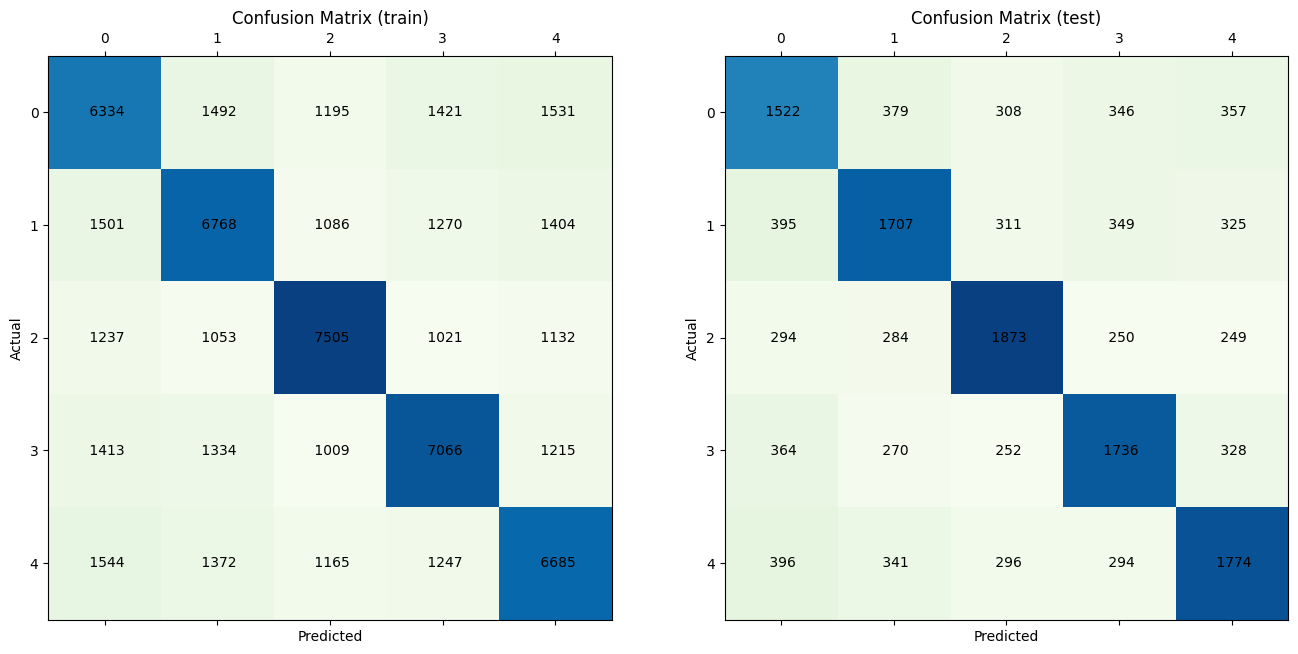

In [200]:
p3_model = FLDA()
p3_model.fit(p3["X"], p3["Y"])
pred = p3_model.predict(p3["X"])
pred_test = p3_model.predict(p3["X_test"])

metrics.print(pred, p3["Y"], pred_test, p3["Y_test"])

------------------ Train ---------------------
Classification Accuracy :  88.40476190476191 %
F1 Score                :  [0.90378869 0.89365628 0.9668858  0.84427429 0.8408551  0.89815043
 0.85488061 0.79873602 0.91883116 0.92919163]
------------------ Test ----------------------
Classification Accuracy :  88.38333333333334 %
F1 Score                :  [0.89511653 0.88997026 0.96818181 0.84026143 0.85205897 0.8973098
 0.85567304 0.79670173 0.92254134 0.92853058]
Confusion Matrix        : 
[[1613  133    2   25   10    0    4    4    8    1]
 [  60 1646    2   56   33    1    0    0    0    2]
 [  24   19 1704   37    2   13    1    0    0    0]
 [  18   26    0 1607   67   23    1   58    0    0]
 [   1    7    0   46 1676   62    0    0    7    1]
 [   1   11   12   46  172 1551    0    1    6    0]
 [   4    5    0   42   27    2 1497  223    0    0]
 [  29    9    0  138   33    1  189 1401    0    0]
 [  24   10    0    4   96    4    0    2 1590   70]
 [  30   33    0   24   18   

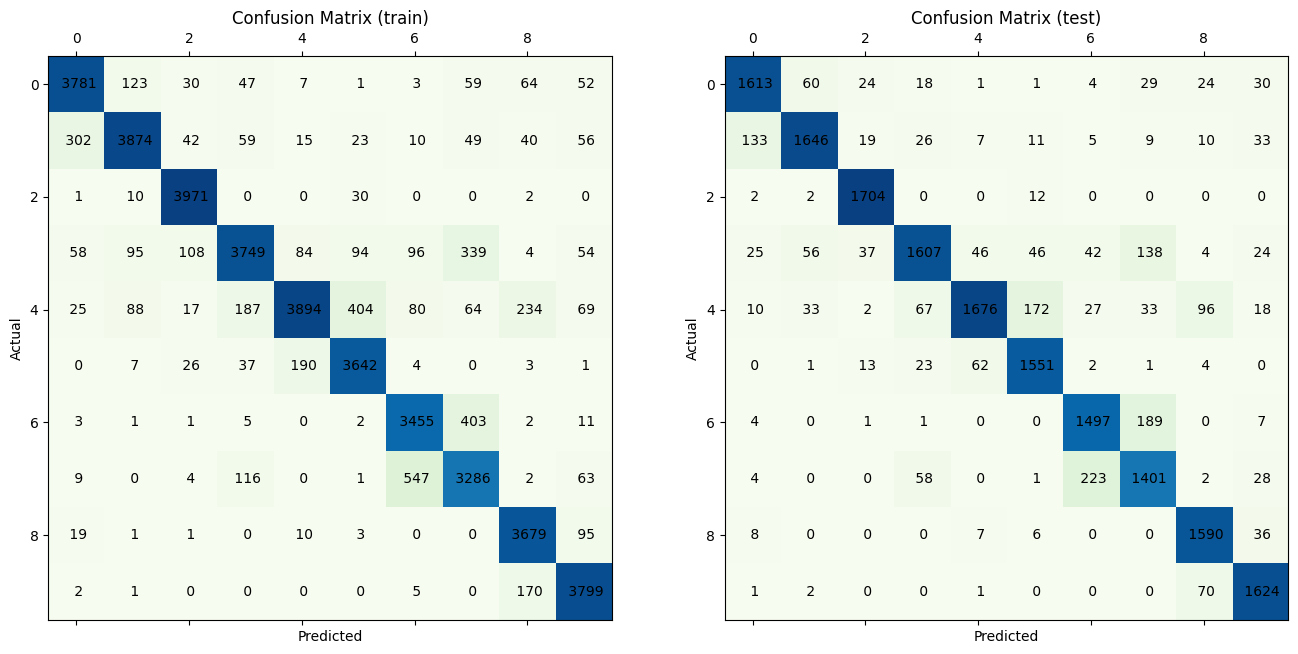

In [270]:
p4_model = FLDA()
p4_model.fit(p4["X"], p4["Y"])
pred = p4_model.predict(p4["X"])
pred_test = p4_model.predict(p4["X_test"])

metrics.print(pred, p4["Y"], pred_test, p4["Y_test"])

------------------ Train ---------------------
Classification Accuracy :  83.59666666666666 %
F1 Score                :  [0.84916966 0.90407358 0.9171587  0.77918215 0.88075965 0.88698234
 0.74750499 0.63678837 0.87582379 0.8871391 ]
------------------ Test ----------------------
Classification Accuracy :  86.26 %
F1 Score                :  [0.88073707 0.90509259 0.91562388 0.85895806 0.92036827 0.88016398
 0.77255985 0.65298776 0.93031123 0.90570021]
Confusion Matrix        : 
[[2581  270    0   49    4    0    3   33   47   13]
 [  63 2737    0  147   10    6    1    3    7   26]
 [  27    9 2561   19    4  366    0    4    9    1]
 [  15    1    4 2704   22   48   20  185    1    0]
 [   0    1    0   47 2849   85    0    3    1   14]
 [   0    7   25   74   84 2791    5    9    4    1]
 [   1    0    0   26    4   12 2517  438    0    2]
 [   1    0    3  187   19   11  965 1814    0    0]
 [ 123   17    1    3   25   17    2    9 2750   53]
 [  50    6    0   40  170    6    3   5

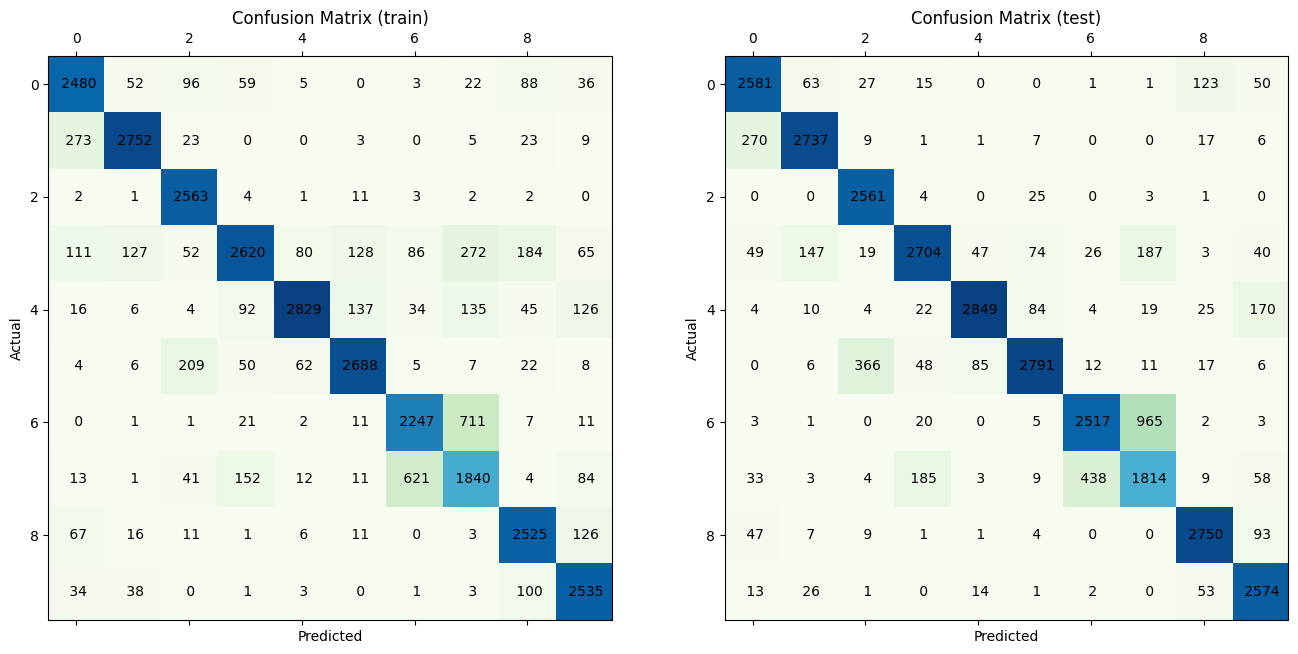

In [202]:
p5_model = FLDA()
p5_model.fit(p5["X"], p5["Y"])
pred = p5_model.predict(p5["X"])
pred_test = p5_model.predict(p5["X_test"])

metrics.print(pred, p5["Y"], pred_test, p5["Y_test"])

# P3 (Regression)

For the regression problem p1 in A1, overfit the data with over-parameterized models (at least 3). 
In the next part, impose different types of regularizers (L2, L1, and a combination of both) and 
plot the bias-variance curves.

**DATA**: `p1train/test.csv`

In [158]:
# Compute mean squared error
def mse(X, Y, W):
    return (1/len(Y)) * (X @ W - Y) @ (X @ W - Y)

# Print the required metrics
def regression(x_train, y_train, x_test, y_test, func = lambda x : x):
    x_train = func(x_train)
    x_test = func(x_test)
    
    m, n = x_train.shape
    w = np.linalg.pinv(x_train) @ y_train

    mse_train = mse(x_train, y_train, w)
    mae_train = mae(x_train, y_train, w)
    p_train = ttest_ind(x_train @ w, y_train).pvalue
    mse_test = mse(x_test, y_test, w)
    mae_test = mae(x_test, y_test, w)
    p_test = ttest_ind(x_test @ w, y_test).pvalue
    
    print("MSE (train-split)     : ", mse_train)
    print("MAE (train-split)     : ", mae_train)
    print("p-value (train-split) : ", p_train)

    print("--------------------------------------")

    print("a) MSE     : ", mse_test)
    print("b) MAE     : ", mae_test)
    print("c) p-value : ", p_test)
    return [mse_train, mae_train, p_train], [mse_test, mae_test, p_test]

In [75]:
X, Y = parseData(p1["train"])
X_test, Y_test = parseData(p1["test"])

# Uniform distribution
p3["result"] = [[] for _ in range(9)]
p3["result"][0] = printResult(X, Y, X_test, Y_test, lambda x : np.ones(x.shape[0]).reshape(x.shape[0], 1))

MSE (train-split)     :  668.234786180195
MAE (train-split)     :  215864.05219664107
p-value (train-split) :  0.9999999999999973
--------------------------------------
a) MSE     :  688.6933406199939
b) MAE     :  110325.60934113807
c) p-value :  0.5482536887507075


/tmp/ipykernel_1435218/1984451752.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_train = ttest_ind(x_train @ w, y_train).pvalue
/tmp/ipykernel_1435218/1984451752.py:43: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_test = ttest_ind(x_test @ w, y_test).pvalue


In [76]:
p3["result"][1] = printResult(X, Y, X_test, Y_test)

MSE (train-split)     :  5.059684615643717
MAE (train-split)     :  17917.53209393991
p-value (train-split) :  0.999999999999998
--------------------------------------
a) MSE     :  5.0464360039512535
b) MAE     :  8995.400265491306
c) p-value :  0.9084780712932894


In [77]:
def makeQuadratic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] for i in range(n) for j in range(n) if j <= i]).T

p3["result"][2] = printResult(X, Y, X_test, Y_test, makeQuadratic)

MSE (train-split)     :  5.057337646427746
MAE (train-split)     :  17912.881059172036
p-value (train-split) :  0.9999999999995446
--------------------------------------
a) MSE     :  5.0460393419222935
b) MAE     :  8994.498298744744
c) p-value :  0.9085274641616161


In [78]:
def makeCubic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] * data.T[k] for i in range(n) for j in range(n) for k in range(n) if j <= i and k <= j]).T

p3["result"][3] = printResult(X, Y, X_test, Y_test, makeCubic)

MSE (train-split)     :  5.055143947861669
MAE (train-split)     :  17911.136229672695
p-value (train-split) :  0.9999999999999603
--------------------------------------
a) MSE     :  5.0504576371743
b) MAE     :  9000.349636098199
c) p-value :  0.907889365818987


## Non-Linear regression (4)
$h_3(x) = h_1(h_1(x))$

In [79]:
p3["result"][4] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(x)))

MSE (train-split)     :  5.052063535022622
MAE (train-split)     :  17903.052149605162
p-value (train-split) :  0.999999999928211
--------------------------------------
a) MSE     :  5.053306488271599
b) MAE     :  9002.643104243063
c) p-value :  0.9112055609046055


## Non-Linear regression (5)
$h_4(x) = h_1(h_2(x))$

In [80]:
p3["result"][5] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeCubic(x)))

MSE (train-split)     :  5.036182828226298
MAE (train-split)     :  17891.20957238561
p-value (train-split) :  0.9999999998032667
--------------------------------------
a) MSE     :  5.059898421648326
b) MAE     :  9012.195988905325
c) p-value :  0.9100196705445498


## Non-Linear regression (6)
$h_5(x) = h_2(h_2(x))$

In [81]:
p3["result"][6] = printResult(X, Y, X_test, Y_test, lambda x : makeCubic(makeCubic(x)))

MSE (train-split)     :  5.025080763598227
MAE (train-split)     :  17871.889903932144
p-value (train-split) :  0.9999838382049027
--------------------------------------
a) MSE     :  5.074239570702316
b) MAE     :  9030.49305673658
c) p-value :  0.9108650785034057


## Non-Linear regression (7)
$h_6(x) = h_1(h_1(h_2(x)))$

In [90]:
p3["result"][7] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(makeCubic(x))))

MSE (train-split)     :  7.278581524675927
MAE (train-split)     :  21009.67687783465
p-value (train-split) :  0.6709381814486539
--------------------------------------
a) MSE     :  7.492180313509383
b) MAE     :  10662.32249665149
c) p-value :  0.6631472355153263


## Non-Linear regression (8)
$h_7(x) = h_1(h_1(h_1(h_1(x))))$

In [ ]:
p3["result"][8] = printResult(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(makeQuadratic(makeQuadratic(x)))))

/tmp/ipykernel_1435218/3727559068.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array(p3["result"])[1:7]


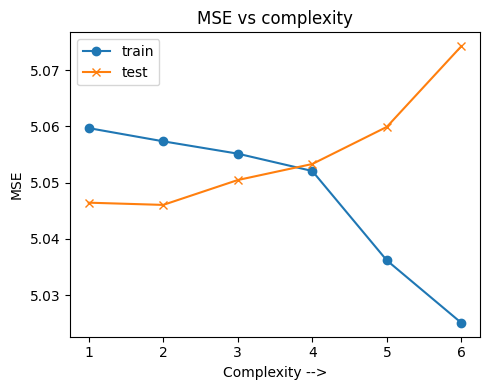

In [89]:
results = np.array(p3["result"])[1:7]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot([i + 1 for i in range(6)], [((row[0][0])) for row in results], label="train", marker='o')
ax.plot([i + 1 for i in range(6)], [((row[1][0])) for row in results], label="test", marker='x')
ax.set_xlabel("Complexity -->")
ax.set_ylabel("MSE")
ax.legend()
ax.set_title("MSE vs complexity")

fig.tight_layout()

# Custom functions for Neural Networks

## 1. Multi-Layer Perceptron

In [ ]:
class MLP:
    def __init__(self, sizes, activation='sigmoid', activation_last_layer='softmax', loss='ce', learning_rate=0.01, random_seed=42):
        np.random.seed(random_seed)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.activation = activation
        self.activation_last_layer = activation_last_layer
        self.loss = loss
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(sizes[i], sizes[i-1]) / np.sqrt(sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(sizes[i], 1) for i in range(1, self.num_layers)]

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_prime(self, z):
        return np.where(z > 0, 1, 0)


    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def softmax_prime(self, z):
        return self.softmax(z) * (1 - self.softmax(z))

    def cross_entropy_loss(self, y, y_pred):
        m = y.shape[1]
        cost = -1/m * np.sum(y * np.log(y_pred + 1e-8))
        return np.squeeze(cost)

    def cross_entropy_loss_prime(self, y, y_pred):
        return y_pred - y

    def squared_error_loss(self, y, y_pred):
        m = y.shape[1]
        cost = 1/(2*m) * np.sum((y_pred - y)**2)
        return np.squeeze(cost)

    def squared_error_loss_prime(self, y, y_pred):
        return y_pred - y

    def forward(self, X):
        a = X.T
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a) + self.biases[i]
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a = self.softmax(z)
            else:
                if self.activation == 'sigmoid':
                    a = self.sigmoid(z)
                elif self.activation == 'relu':
                    a = self.relu(z)
                    
        return a.T


    def backward(self, X, y):
        m = X.shape[0]
        a = [X.T]
        z_s = []
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a[-1]) + self.biases[i]
            z_s.append(z)
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a.append(self.softmax(z))
            else:
                if self.activation == 'sigmoid':
                    a.append(self.sigmoid(z))
                elif self.activation == 'relu':
                    a.append(self.relu(z))
                    
        if self.loss == 'ce':
            d_a = self.cross_entropy_loss_prime(y.T, a[-1])
        elif self.loss == 'mse':
            d_a = self.squared_error_loss_prime(y.T, a[-1])
            
        d_z = d_a
        d_weights = []
        d_biases = []
        for i in range(self.num_layers-2, -1, -1):
            d_weights.insert(0, np.dot(d_z, a[i].T) / m)
            d_biases.insert(0, np.sum(d_z, axis=1, keepdims=True) / m)
            if i > 0:
                if self.activation == 'sigmoid':
                    d_z = np.dot(self.weights[i].T, d_z) * self.sigmoid_prime(z_s[i-1])
                elif self.activation == 'relu':
                    d_z = np.dot(self.weights[i].T, d_z) * self.relu_prime(z_s[i-1])
                    
        return d_weights, d_biases
    

    def train(self, X_train, Y_train, X_val, Y_val, num_epochs, batch_size): 
        n_labels = len(np.unique(Y_train))
        y_train, y_val = [np.zeros((y.shape[0], n_labels)) for y in [Y_train, Y_val]]
        for i, j in enumerate(Y_train):
            y_train[i][int(j)] = 1
        for i, j in enumerate(Y_val):
            y_val[i][int(j)] = 1   
            
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for i in range(num_epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_train = X_train[permutation, :]
            y_train = y_train[permutation]
            
            for j in range(0, X_train.shape[0], batch_size):
                
                X_batch = X_train[j : j + batch_size, :]
                y_batch = y_train[j : j + batch_size]
                
                d_weights, d_biases = self.backward(X_batch, y_batch)
                
                for k in range(len(self.weights)):
                    self.weights[k] -= self.learning_rate * d_weights[k]
                    self.biases[k] -= self.learning_rate * d_biases[k]
                    
            y_pred_train = self.forward(X_train)
            y_pred_val = self.forward(X_val)
            
            if self.loss == 'ce':
                train_loss = self.cross_entropy_loss(y_train, y_pred_train)
                val_loss = self.cross_entropy_loss(y_val, y_pred_val)
            elif self.loss == 'mse':
                train_loss = self.squared_error_loss(y_train, y_pred_train)
                val_loss = self.squared_error_loss(y_val, y_pred_val)
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            acc_params_train = [np.argmax(y_train, axis=1), np.argmax(y_pred_train, axis=1)]
            acc_params_val = [np.argmax(y_val, axis=1), np.argmax(y_pred_val, axis=1)]
            
            train_acc = metrics.accuracy(*acc_params_train)
            val_acc = metrics.accuracy(*acc_params_val)
            
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            # train_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_train, n_labels))
            # val_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_val, n_labels))
            
            print(f"Epoch {i+1}: \t  train_loss = {train_loss:.2f}  \tval_loss = {val_loss:.2f} \t  train_acc = {train_acc:.2f}  \t val_acc = {val_acc:.2f}")
        return train_losses, val_losses, train_accs, val_accs

# P4 (Neural Networks, MLP)

- Construct a Multi-layer Perception (MLP) or a feed-forward neural network to work on the K-MNIST dataset. 
- Experiment with at least 3 settings of the number of hidden layers and Neurons. 
- Explicitly code the Error Backpropagation algorithm as a class and use it on MLPs with different architectures and loss functions (CE, squared error loss).
- For this part, you should only use Numpy. 

Report the accuracy and F1 scores with all the considered configurations.

**DATA:** `images.zip (p4['data'])`

In [276]:
mlp = [[] for _ in range(4)]
n_labels = len(np.unique(p4['Y']))

# Shuffle the training data randomly
indices = np.arange(p4['X'].shape[0])
np.random.shuffle(indices)

s = int(0.7 * p4['X'].shape[0])
xtrain, xval = p4['X'][indices[:s]], p4['X'][indices[s:]]
ytrain, yval = p4['Y'][indices[:s]], p4['Y'][indices[s:]]

layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[0] = MLP(layers, 'sigmoid', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[0].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 6772.50  	val_loss = 2904.61 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 6772.33  	val_loss = 2904.17 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 6771.86  	val_loss = 2904.27 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = 6772.97  	val_loss = 2904.68 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = 6771.38  	val_loss = 2903.73 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = 6772.12  	val_loss = 2902.43 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = 6772.88  	val_loss = 2904.64 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = 6772.63  	val_loss = 2904.06 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = 6774.03  	val_loss = 2903.83 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = 6770.47  	val_loss = 2902.42 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = 6770.81  	val_loss = 2903.38 	  train_acc = 0.10  	 v

In [277]:
layers = [xtrain.shape[1], 256, 128, 64, 32, n_labels]
mlp[1] = MLP(layers, 'relu', 'softmax','ce', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[1].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 6724.05  	val_loss = 2882.97 	  train_acc = 0.14  	 val_acc = 0.13
Epoch 2: 	  train_loss = 6691.24  	val_loss = 2868.91 	  train_acc = 0.24  	 val_acc = 0.24
Epoch 3: 	  train_loss = 6662.83  	val_loss = 2856.92 	  train_acc = 0.22  	 val_acc = 0.22
Epoch 4: 	  train_loss = 6618.63  	val_loss = 2837.89 	  train_acc = 0.20  	 val_acc = 0.19
Epoch 5: 	  train_loss = 6555.90  	val_loss = 2809.07 	  train_acc = 0.42  	 val_acc = 0.43
Epoch 6: 	  train_loss = 6469.59  	val_loss = 2773.06 	  train_acc = 0.43  	 val_acc = 0.44
Epoch 7: 	  train_loss = 6342.79  	val_loss = 2718.56 	  train_acc = 0.43  	 val_acc = 0.43
Epoch 8: 	  train_loss = 6170.58  	val_loss = 2641.76 	  train_acc = 0.37  	 val_acc = 0.38
Epoch 9: 	  train_loss = 6015.64  	val_loss = 2583.87 	  train_acc = 0.25  	 val_acc = 0.26
Epoch 10: 	  train_loss = 6260.84  	val_loss = 2697.50 	  train_acc = 0.11  	 val_acc = 0.11
Epoch 11: 	  train_loss = 6514.92  	val_loss = 2778.25 	  train_acc = 0.13  	 v

In [278]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[2] = MLP(layers, 'sigmoid', 'softmax','mse', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[2].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 1337.57  	val_loss = 573.80 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 1324.50  	val_loss = 567.93 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 1323.09  	val_loss = 567.22 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = 1322.97  	val_loss = 567.15 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = 1322.96  	val_loss = 567.13 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = 1322.95  	val_loss = 567.12 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = 1322.96  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.

In [279]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[3] = MLP(layers, 'relu', 'softmax','mse', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[3].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 1312.71  	val_loss = 562.93 	  train_acc = 0.20  	 val_acc = 0.19
Epoch 2: 	  train_loss = 1277.06  	val_loss = 547.29 	  train_acc = 0.23  	 val_acc = 0.22
Epoch 3: 	  train_loss = 1189.88  	val_loss = 511.03 	  train_acc = 0.21  	 val_acc = 0.21
Epoch 4: 	  train_loss = 1200.20  	val_loss = 512.60 	  train_acc = 0.22  	 val_acc = 0.23
Epoch 5: 	  train_loss = 1171.75  	val_loss = 501.69 	  train_acc = 0.26  	 val_acc = 0.26
Epoch 6: 	  train_loss = 1332.70  	val_loss = 570.87 	  train_acc = 0.16  	 val_acc = 0.16
Epoch 7: 	  train_loss = 1235.68  	val_loss = 528.01 	  train_acc = 0.20  	 val_acc = 0.20
Epoch 8: 	  train_loss = 896.68  	val_loss = 385.17 	  train_acc = 0.53  	 val_acc = 0.53
Epoch 9: 	  train_loss = 1268.54  	val_loss = 543.07 	  train_acc = 0.16  	 val_acc = 0.16
Epoch 10: 	  train_loss = 823.57  	val_loss = 351.75 	  train_acc = 0.58  	 val_acc = 0.58
Epoch 11: 	  train_loss = 1075.34  	val_loss = 461.84 	  train_acc = 0.35  	 val_acc = 0.35

#### Final accuracy and F1 score

In [280]:
models = ["3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "4 hidden layers, activation function: 'relu', loss function: 'mean squared error'",
         "3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "3 hidden layers, activation function: 'relu', loss function: 'mean squared error'"]

for i in range(4):
    pred = np.argmax(mlp[i].forward(p4['X_test']), axis=1)
    cnf = metrics.confusionMatrix(pred, p4['Y_test'], n_labels)
    acc = metrics.accuracy(pred, p4['Y_test'])
    f1 = metrics.f1Score(cnf)
                         
    print(models[i])
    print("Classification Accuracy : ", acc * 100, "%")
    print("               F1 Score : ", np.mean(f1))
    print("-------------------------------------------------------------------------------------")

3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  21.205555555555556 %
               F1 Score :  0.09491137271588837
-------------------------------------------------------------------------------------
4 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  85.62222222222222 %
               F1 Score :  0.8556740540704817
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  10.0 %
               F1 Score :  0.01819008623753513
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  89.3 %
               F1 Score :  0.893049386450607
----------------------------------------------------------------------

# P5 (Neural Networks, CNN)

- Construct a CNN for the K-MNIST dataset and code the back-propagation algorithm with weight sharing and local-receptive fields. 
- Experiment with 3 different architectures and report the accuracy.

**DATA:** `images.zip (p4[data])`

# P6 (Neural Networks, CNN)

- For the above problem, build a big-enough CNN architecture that would overfit the K-MNIST data. 
- Impose L2 and early-stopping as regularizers and plot the bias-variance curves. 
- Perturb each of the input images with additive Gaussian noise and report its regularization impact.

**DATA:** `images.zip (p4[data])`

# P7 (Neural Networks, MLP)

Train an MLP on the PCA counterpart of the KMINST dataset and report your observations

**DATA:** `p5[data]`

In [286]:
mlp = [[] for _ in range(4)]
n_labels = len(np.unique(p4['Y']))

# Shuffle the training data randomly
indices = np.arange(p5['X'].shape[0])
np.random.shuffle(indices)

s = int(0.7 * p5['X'].shape[0])
xtrain, xval = p5['X'][indices[:s]], p5['X'][indices[s:]]
ytrain, yval = p5['Y'][indices[:s]], p5['Y'][indices[s:]]

layers = [xtrain.shape[1], 32, n_labels]
mlp[0] = MLP(layers, 'sigmoid', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[0].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch 1: 	  train_loss = 1901.53  	val_loss = 821.29 	  train_acc = 0.82  	 val_acc = 0.82
Epoch 2: 	  train_loss = 1331.07  	val_loss = 577.65 	  train_acc = 0.85  	 val_acc = 0.85
Epoch 3: 	  train_loss = 1130.10  	val_loss = 491.74 	  train_acc = 0.86  	 val_acc = 0.86
Epoch 4: 	  train_loss = 1041.30  	val_loss = 459.21 	  train_acc = 0.87  	 val_acc = 0.86
Epoch 5: 	  train_loss = 965.91  	val_loss = 426.14 	  train_acc = 0.88  	 val_acc = 0.87
Epoch 6: 	  train_loss = 935.50  	val_loss = 413.98 	  train_acc = 0.87  	 val_acc = 0.87
Epoch 7: 	  train_loss = 884.92  	val_loss = 394.73 	  train_acc = 0.88  	 val_acc = 0.88
Epoch 8: 	  train_loss = 859.36  	val_loss = 383.16 	  train_acc = 0.88  	 val_acc = 0.88
Epoch 9: 	  train_loss = 835.14  	val_loss = 374.90 	  train_acc = 0.89  	 val_acc = 0.88
Epoch 10: 	  train_loss = 810.50  	val_loss = 365.90 	  train_acc = 0.89  	 val_acc = 0.88
Epoch 11: 	  train_loss = 790.91  	val_loss = 356.96 	  train_acc = 0.89  	 val_acc = 0.89
Epoc

In [287]:
layers = [xtrain.shape[1], 64, 32, n_labels]
mlp[1] = MLP(layers, 'relu', 'softmax','mse', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[1].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:28: RuntimeWarning: invalid value encountered in divide
  return exp_z / np.sum(exp_z, axis=0, keepdims=True)


Epoch 1: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 12: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_

In [288]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[2] = MLP(layers, 'sigmoid', 'softmax','mse', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[2].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch 1: 	  train_loss = 940.97  	val_loss = 403.33 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 928.85  	val_loss = 398.03 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 901.26  	val_loss = 386.18 	  train_acc = 0.53  	 val_acc = 0.54
Epoch 4: 	  train_loss = 855.13  	val_loss = 366.33 	  train_acc = 0.58  	 val_acc = 0.59
Epoch 5: 	  train_loss = 768.32  	val_loss = 329.10 	  train_acc = 0.70  	 val_acc = 0.70
Epoch 6: 	  train_loss = 656.37  	val_loss = 281.27 	  train_acc = 0.78  	 val_acc = 0.78
Epoch 7: 	  train_loss = 538.16  	val_loss = 230.81 	  train_acc = 0.80  	 val_acc = 0.80
Epoch 8: 	  train_loss = 435.75  	val_loss = 187.01 	  train_acc = 0.84  	 val_acc = 0.83
Epoch 9: 	  train_loss = 368.09  	val_loss = 158.20 	  train_acc = 0.84  	 val_acc = 0.84
Epoch 10: 	  train_loss = 317.87  	val_loss = 137.24 	  train_acc = 0.85  	 val_acc = 0.85
Epoch 11: 	  train_loss = 281.98  	val_loss = 122.28 	  train_acc = 0.86  	 val_acc = 0.86
Epoch 12

In [289]:
layers = [xtrain.shape[1], 256, 128, 64, 32, n_labels]
mlp[3] = MLP(layers, 'relu', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[3].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:28: RuntimeWarning: invalid value encountered in divide
  return exp_z / np.sum(exp_z, axis=0, keepdims=True)


Epoch 1: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 12: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_

#### Final accuracy and F1 score

In [291]:
models = ["1 hidden layer, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "2 hidden layers, activation function: 'relu', loss function: 'mean squared error'",
         "3 hidden layers, activation function: 'sigmoid', loss function: 'mean squared error'",
         "4 hidden layers, activation function: 'relu', loss function: 'cross-entropy'"]

for i in range(4):
    pred = np.argmax(mlp[i].forward(p5['X_test']), axis=1)
    cnf = metrics.confusionMatrix(pred, p5['Y_test'], n_labels)
    acc = metrics.accuracy(pred, p5['Y_test'])
    f1 = metrics.f1Score(cnf)
                         
    print(models[i])
    print("Classification Accuracy : ", acc * 100, "%")
    print("               F1 Score : ", np.mean(f1))
    print("-------------------------------------------------------------------------------------")

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


1 hidden layer, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  92.05666666666666 %
               F1 Score :  0.9205688141449585
-------------------------------------------------------------------------------------
2 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  10.0 %
               F1 Score :  0.018181818016517907
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'sigmoid', loss function: 'mean squared error'
Classification Accuracy :  92.99 %
               F1 Score :  0.929918543157336
-------------------------------------------------------------------------------------
4 hidden layers, activation function: 'relu', loss function: 'cross-entropy'
Classification Accuracy :  10.0 %
               F1 Score :  0.018181818016517907
----------------------------------------------------------------------------------